In [11]:
import pandas as pd
import numpy as np
from itertools import combinations
import statistics
import math
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing

In [478]:
df = pd.read_excel("./Image_based_data/Per_lesion.xlsx", engine='openpyxl')
delete_case = np.array(df['제외번호 case ID'])[:20].astype(int)
case_map = df[['배포용 순서 1', 'No.']][:100].astype(int)

def map(i):
    if i not in list(case_map['배포용 순서 1']):
        print(f'{i} is not in case_map')
    idx = list(case_map['배포용 순서 1']).index(i)
    
    return case_map['No.'][idx]  

In [479]:
5 not in delete_case

False

In [350]:
def preprocess_(rate):
    rate = rate.sort_values(by=['DB_PatientId'])
    if '2D__maskpos' in rate.columns:
        rate = rate[['DB_PatientId', '2D__maskpos']]
        rate.rename(columns={'2D__maskpos':'2D_maskpos'},inplace=True)
    rate = rate[['DB_PatientId','2D_maskpos']].fillna(0)

    coor_lst = []
    for x in rate['2D_maskpos']:
        if x == 0: coor_lst.append(0)
        else:
            coor = np.array([int(x.split('-')[0][1:-1].split(',')[0])
                            ,int(x.split('-')[0][1:-1].split(',')[1])
                            ,int(x.split('-')[1][1:-1].split(',')[0])
                            ,int(x.split('-')[1][1:-1].split(',')[1])])
            coor_lst.append(coor)

    rate['mask'] = coor_lst
    rate = rate[['DB_PatientId', 'mask']]
    
    ####### AI의 경우에는 이 작업 안해도 됨##############
    rate = rate[~rate['DB_PatientId'].isin(delete_case)]
#     rate['DB_PatientId'] = [map(i) for i in rate['DB_PatientId']]
    
    rate.to_csv('./hihihi.csv',index=None)
    
    return rate

In [216]:
for data in glob('./Reader_test_data/*/*.csv'):
    dest = f'./Reader_test_lesion{data[18:]}'
    new_df = preprocess_(pd.read_csv(data))
    new_df.to_csv(dest,index=None)

In [351]:
preprocess_(pd.read_csv(glob('./Reader_test_data/Reader_AI+/R12_2.csv')[0]))[:20]

,DB_PatientId,mask
0,1,"[1714, 961, 1911, 1187]"
118,2,0
1,3,0
2,4,0
5,7,0
6,8,"[814, 1951, 962, 2140]"
7,9,0
8,11,0
9,12,0
10,13,"[590, 341, 688, 451]"


In [335]:
for data in glob('./Reader_test_data/Reader_AI+/R12_2.csv'):
    dest = f'./Reader_test_lesion{data[18:]}'
    new_df = preprocess_(pd.read_csv(data))
    new_df.to_csv(dest,index=None)

In [217]:
def lesiondf2imagedf(lesion_df):
    df = lesion_df.drop_duplicates(['DB_PatientId'])
    df['Answer'] = list(df['mask'] != '0')
    df['Answer'] = df['Answer'].replace({True:1, False:0})
    df = df.sort_values(by=['DB_PatientId'])
    df = df[['Answer']]
    
    return df

In [218]:
for data in glob('./Reader_test_lesion/*/*.csv'):
    dest = f'./Reader_test_image{data[20:]}'
    new_df = lesiondf2imagedf(pd.read_csv(data))
    new_df.to_csv(dest,index=None)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


# Bootstrap

In [1469]:
SAMPLE_SIZE = 50
ITERATION = 100

In [1304]:
# PatientId(1~100)
sample_ids = []
for _ in range(ITERATION):
    x = np.random.choice(range(1,101), size=SAMPLE_SIZE, replace=True)
    x.sort()
    sample_ids.append(list(x))

# sample_ids

In [1305]:
# import pickle 

# with open(f"./bootstrap_readertest", "wb") as fp:   #Pickling
#     pickle.dump(sample_ids, fp)

In [12]:
with open(f"./bootstrap_readertest", "rb") as fp:   # Unpickling
    sample_ids = pickle.load(fp)

In [1356]:
# without bootstrap
sample_ids = [list(range(1,101))]

# Image-based

In [1669]:
def TPTNFPFN(x, answer):
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    for i in range(len(answer)):
        if answer[i] == 1:
            if x[i] == 1:
                TP += 1
            elif x[i] == 0:
                FN += 1
        elif answer[i] == 0:
            if x[i] == 0:
                TN += 1
            elif x[i] == 1:
                FP += 1
#     print(f'TP is {TP}')
#     print(f'TN is {TN}')
#     print(f'FP is {FP}')
#     print(f'FN is {FN}')
    return TP, TN, FP, FN

def accuracy(gt, target):
    TP, TN, FP, FN = TPTNFPFN(target, gt)

    sensitivity = TP / (TP+FN)
    specificity = TN / (TN+FP)
    accuracy = (TP+TN)/(TP+FP+TN+FN)

    print(f'TP {TP}')
    print(f'FP {FP}')
    print(f'TN {TN}')
    print(f'FN {FN}')
    print(f'sensitivity {sensitivity}')
    print(f'specificity {specificity}')
    print(f'accuracy {accuracy}')

    return sensitivity, specificity, accuracy

In [13]:
raters = ['R12', 'R13', 'R17', 'R18', 'R19', 'R22', 'R24', 'R25', 'R27', 'R30']

In [1671]:
def accuracies(gt_df, target_df, samples):
    sensitivities_ = []
    specificities_ = []
    accuracies_ = []
    for sample in samples:
        sample = list(np.array(sample)-1)
        sample_gt = gt_df.iloc[sample].reset_index(drop=True)
        sample_target = target_df.iloc[sample].reset_index(drop=True)
        acc = accuracy(sample_gt[sample_gt.columns[0]], sample_target[sample_target.columns[0]])
        sensitivities_.append(acc[0])
        specificities_.append(acc[1])
        accuracies_.append(acc[2])
        
    return sensitivities_, specificities_, accuracies_

In [1672]:
ct = pd.read_csv(f'./constructed/image-based_CT.csv')
indiv = pd.read_csv(f'./constructed/image-based_1_majority_votes.csv')[['1vote4']] # R20
mv3 = pd.read_csv(f'./constructed/image-based_3_majority_votes.csv')[['3vote38']]
mv5 = pd.read_csv(f'./constructed/image-based_5_majority_votes.csv')[['5vote17']]
mv7 = pd.read_csv(f'./constructed/image-based_7_majority_votes.csv')[['7vote7']]
mv9 = pd.read_csv(f'./constructed/image-based_9_majority_votes.csv')[['9vote0']]
cons2 = pd.read_csv(f'./constructed/image-based_consensus2.csv')
cons3 = pd.read_csv(f'./constructed/image-based_consensus3.csv')
lca2 = pd.read_csv(f'./constructed/image-based_lca_2.csv')
lca3 = pd.read_csv(f'./constructed/image-based_lca_3.csv')

In [1574]:
woAI = []
wAI = []

for rater in raters:
    woAI.append(pd.read_csv(f'./Reader_test_image/Reader_AI-/{rater}_1.csv'))
    wAI.append(pd.read_csv(f'./Reader_test_image/Reader_AI+/{rater}_2.csv'))

AI = pd.read_csv(f'./Reader_test_image/AI/AI.csv')

In [1575]:
ct_woAI_scores = []
ct_wAI_scores = []
indiv_woAI_scores = []
indiv_wAI_scores = []
mv3_woAI_scores = []
mv3_wAI_scores = []
mv5_woAI_scores = []
mv5_wAI_scores = []
mv7_woAI_scores = []
mv7_wAI_scores = []
mv9_woAI_scores = []
mv9_wAI_scores = []
cons2_woAI_scores = []
cons2_wAI_scores = []
cons3_woAI_scores = []
cons3_wAI_scores = []
lca2_woAI_scores = []
lca2_wAI_scores = []
lca3_woAI_scores = []
lca3_wAI_scores = []

In [1576]:
np.array(lca2_woAI_scores).shape

(0,)

In [1577]:
for target in woAI:
    ct_woAI_scores.append(accuracies(ct, target, sample_ids))
    indiv_woAI_scores.append(accuracies(indiv, target, sample_ids))
    mv3_woAI_scores.append(accuracies(mv3, target, sample_ids))
    mv5_woAI_scores.append(accuracies(mv5, target, sample_ids))
    mv7_woAI_scores.append(accuracies(mv7, target, sample_ids))
    mv9_woAI_scores.append(accuracies(mv9, target, sample_ids))
    cons2_woAI_scores.append(accuracies(cons2, target, sample_ids))
    cons3_woAI_scores.append(accuracies(cons3, target, sample_ids))
    lca2_woAI_scores.append(accuracies(lca2, target, sample_ids))
    lca3_woAI_scores.append(accuracies(lca3, target, sample_ids))

TP 17
FP 0
TN 23
FN 10
sensitivity 0.6296296296296297
specificity 1.0
accuracy 0.8
TP 17
FP 1
TN 23
FN 9
sensitivity 0.6538461538461539
specificity 0.9583333333333334
accuracy 0.8
TP 11
FP 1
TN 25
FN 13
sensitivity 0.4583333333333333
specificity 0.9615384615384616
accuracy 0.72
TP 14
FP 1
TN 28
FN 7
sensitivity 0.6666666666666666
specificity 0.9655172413793104
accuracy 0.84
TP 11
FP 0
TN 22
FN 17
sensitivity 0.39285714285714285
specificity 1.0
accuracy 0.66
TP 12
FP 0
TN 30
FN 8
sensitivity 0.6
specificity 1.0
accuracy 0.84
TP 9
FP 0
TN 23
FN 18
sensitivity 0.3333333333333333
specificity 1.0
accuracy 0.64
TP 13
FP 1
TN 24
FN 12
sensitivity 0.52
specificity 0.96
accuracy 0.74
TP 15
FP 2
TN 22
FN 11
sensitivity 0.5769230769230769
specificity 0.9166666666666666
accuracy 0.74
TP 9
FP 0
TN 29
FN 12
sensitivity 0.42857142857142855
specificity 1.0
accuracy 0.76
TP 8
FP 0
TN 33
FN 9
sensitivity 0.47058823529411764
specificity 1.0
accuracy 0.82
TP 15
FP 1
TN 21
FN 13
sensitivity 0.5357142857142

KeyboardInterrupt: 

In [1479]:
for target in wAI:
    ct_wAI_scores.append(accuracies(ct, target, sample_ids))
    indiv_wAI_scores.append(accuracies(indiv, target, sample_ids))
    mv3_wAI_scores.append(accuracies(mv3, target, sample_ids))
    mv5_wAI_scores.append(accuracies(mv5, target, sample_ids))
    mv7_wAI_scores.append(accuracies(mv7, target, sample_ids))
    mv9_wAI_scores.append(accuracies(mv9, target, sample_ids))
    cons2_wAI_scores.append(accuracies(cons2, target, sample_ids))
    cons3_wAI_scores.append(accuracies(cons3, target, sample_ids))
    lca2_wAI_scores.append(accuracies(lca2, target, sample_ids))
    lca3_wAI_scores.append(accuracies(lca3, target, sample_ids))

TP 17
FP 0
TN 23
FN 10
sensitivity 0.6296296296296297
specificity 1.0
accuracy 0.8
TP 16
FP 0
TN 24
FN 10
sensitivity 0.6153846153846154
specificity 1.0
accuracy 0.8
TP 16
FP 0
TN 26
FN 8
sensitivity 0.6666666666666666
specificity 1.0
accuracy 0.84
TP 11
FP 0
TN 29
FN 10
sensitivity 0.5238095238095238
specificity 1.0
accuracy 0.8
TP 13
FP 0
TN 22
FN 15
sensitivity 0.4642857142857143
specificity 1.0
accuracy 0.7
TP 11
FP 0
TN 30
FN 9
sensitivity 0.55
specificity 1.0
accuracy 0.82
TP 10
FP 0
TN 23
FN 17
sensitivity 0.37037037037037035
specificity 1.0
accuracy 0.66
TP 15
FP 0
TN 25
FN 10
sensitivity 0.6
specificity 1.0
accuracy 0.8
TP 12
FP 0
TN 24
FN 14
sensitivity 0.46153846153846156
specificity 1.0
accuracy 0.72
TP 10
FP 0
TN 29
FN 11
sensitivity 0.47619047619047616
specificity 1.0
accuracy 0.78
TP 7
FP 0
TN 33
FN 10
sensitivity 0.4117647058823529
specificity 1.0
accuracy 0.8
TP 19
FP 0
TN 22
FN 9
sensitivity 0.6785714285714286
specificity 1.0
accuracy 0.82
TP 15
FP 0
TN 23
FN 12
sensi

In [1480]:
ct_AI_scores = accuracies(ct, AI, sample_ids)
indiv_AI_scores = accuracies(indiv, AI, sample_ids)
mv3_AI_scores = accuracies(mv3, AI, sample_ids)
mv5_AI_scores = accuracies(mv5, AI, sample_ids)
mv7_AI_scores = accuracies(mv7, AI, sample_ids)
mv9_AI_scores = accuracies(mv9, AI, sample_ids)
cons2_AI_scores = accuracies(cons2, AI, sample_ids)
cons3_AI_scores = accuracies(cons3, AI, sample_ids)
lca2_AI_scores = accuracies(lca2, AI, sample_ids)
lca3_AI_scores = accuracies(lca3, AI, sample_ids)

TP 22
FP 0
TN 23
FN 5
sensitivity 0.8148148148148148
specificity 1.0
accuracy 0.9
TP 21
FP 0
TN 24
FN 5
sensitivity 0.8076923076923077
specificity 1.0
accuracy 0.9
TP 19
FP 0
TN 26
FN 5
sensitivity 0.7916666666666666
specificity 1.0
accuracy 0.9
TP 20
FP 0
TN 29
FN 1
sensitivity 0.9523809523809523
specificity 1.0
accuracy 0.98
TP 23
FP 0
TN 22
FN 5
sensitivity 0.8214285714285714
specificity 1.0
accuracy 0.9
TP 17
FP 0
TN 30
FN 3
sensitivity 0.85
specificity 1.0
accuracy 0.94
TP 20
FP 0
TN 23
FN 7
sensitivity 0.7407407407407407
specificity 1.0
accuracy 0.86
TP 17
FP 0
TN 25
FN 8
sensitivity 0.68
specificity 1.0
accuracy 0.84
TP 25
FP 0
TN 24
FN 1
sensitivity 0.9615384615384616
specificity 1.0
accuracy 0.98
TP 16
FP 0
TN 29
FN 5
sensitivity 0.7619047619047619
specificity 1.0
accuracy 0.9
TP 12
FP 0
TN 33
FN 5
sensitivity 0.7058823529411765
specificity 1.0
accuracy 0.9
TP 24
FP 0
TN 22
FN 4
sensitivity 0.8571428571428571
specificity 1.0
accuracy 0.92
TP 24
FP 0
TN 23
FN 3
sensitivity 0.88

## Distribution Comparison

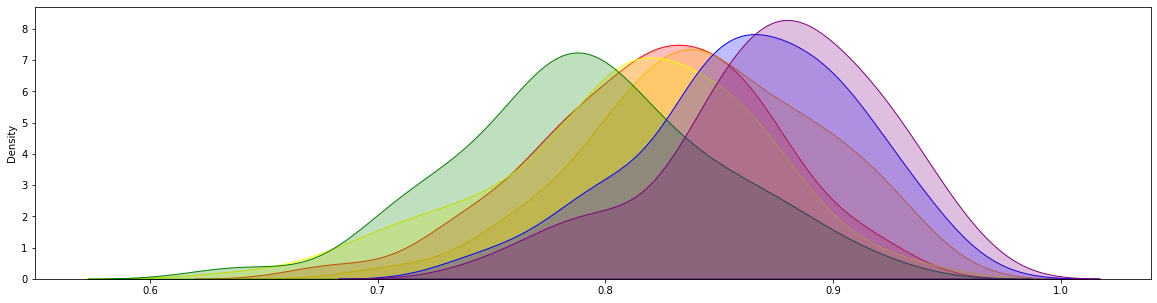

In [91]:
# plt.figure(figsize=(20,5))

# sns.kdeplot(data = indiv_acc, color="red", shade=True)
# sns.kdeplot(data = mv_acc, color="orange", shade=True)
# sns.kdeplot(data = cons2_acc, color="yellow", shade=True)
# sns.kdeplot(data = cons3_acc, color="green", shade=True)
# sns.kdeplot(data = lca2_acc, color="blue", shade=True)
# sns.kdeplot(data = lca3_acc, color="purple", shade=True)
# plt.show()

In [1048]:
import pickle

list_dict = {'ct_woAI_scores': ct_woAI_scores,'ct_wAI_scores': ct_wAI_scores,'ct_AI_scores': ct_AI_scores,
            'indiv_woAI_scores': indiv_woAI_scores,'indiv_wAI_scores': indiv_wAI_scores,'indiv_AI_scores': indiv_AI_scores,
            'mv3_woAI_scores': mv3_woAI_scores,'mv3_wAI_scores': mv3_wAI_scores,'mv3_AI_scores': mv3_AI_scores,
            'mv5_woAI_scores': mv5_woAI_scores,'mv5_wAI_scores': mv5_wAI_scores,'mv5_AI_scores': mv5_AI_scores,
            'mv7_woAI_scores': mv7_woAI_scores,'mv7_wAI_scores': mv7_wAI_scores,'mv7_AI_scores': mv7_AI_scores,
            'mv9_woAI_scores': mv9_woAI_scores,'mv9_wAI_scores': mv9_wAI_scores,'mv9_AI_scores': mv9_AI_scores,
            'cons2_woAI_scores': cons2_woAI_scores,'cons2_wAI_scores': cons2_wAI_scores,'cons2_AI_scores': cons2_AI_scores,
            'cons3_woAI_scores': cons3_woAI_scores,'cons3_wAI_scores': cons3_wAI_scores,'cons3_AI_scores': cons3_AI_scores,
            'lca2_woAI_scores': lca2_woAI_scores,'lca2_wAI_scores': lca2_wAI_scores,'lca2_AI_scores': lca2_AI_scores,
            'lca3_woAI_scores': lca3_woAI_scores,'lca3_wAI_scores': lca3_wAI_scores,'lca3_AI_scores': lca3_AI_scores}

# for name in list_dict.keys():
#     with open(f"./Reader_test_result/image/{name}", "wb") as fp:   #Pickling
#         pickle.dump(list_dict[name], fp)

# for name in list_dict.keys():zz
#     with open(f"./Reader_test_result/image_bootstrap/{name}", "wb") as fp:   #Pickling
#         pickle.dump(list_dict[name], fp)


In [816]:
list_dict.keys()

dict_keys(['ct_woAI_scores', 'ct_wAI_scores', 'ct_AI_scores', 'indiv_woAI_scores', 'indiv_wAI_scores', 'indiv_AI_scores', 'mv3_woAI_scores', 'mv3_wAI_scores', 'mv3_AI_scores', 'mv5_woAI_scores', 'mv5_wAI_scores', 'mv5_AI_scores', 'mv7_woAI_scores', 'mv7_wAI_scores', 'mv7_AI_scores', 'mv9_woAI_scores', 'mv9_wAI_scores', 'mv9_AI_scores', 'cons2_woAI_scores', 'cons2_wAI_scores', 'cons2_AI_scores', 'cons3_woAI_scores', 'cons3_wAI_scores', 'cons3_AI_scores', 'lca2_woAI_scores', 'lca2_wAI_scores', 'lca2_AI_scores', 'lca3_woAI_scores', 'lca3_wAI_scores', 'lca3_AI_scores'])

In [14]:
dict_keys = ['ct_woAI_scores', 'ct_wAI_scores', 'ct_AI_scores',
             'indiv_woAI_scores', 'indiv_wAI_scores', 'indiv_AI_scores', 
             'mv3_woAI_scores', 'mv3_wAI_scores', 'mv3_AI_scores', 
             'mv5_woAI_scores', 'mv5_wAI_scores', 'mv5_AI_scores', 
             'mv7_woAI_scores', 'mv7_wAI_scores', 'mv7_AI_scores', 
             'mv9_woAI_scores', 'mv9_wAI_scores', 'mv9_AI_scores', 
             'cons2_woAI_scores', 'cons2_wAI_scores', 'cons2_AI_scores', 
             'cons3_woAI_scores', 'cons3_wAI_scores', 'cons3_AI_scores', 
             'lca2_woAI_scores', 'lca2_wAI_scores', 'lca2_AI_scores', 
             'lca3_woAI_scores', 'lca3_wAI_scores', 'lca3_AI_scores']

# for key in dict_keys:
#     with open(f"./Reader_test_result/image/{key}", "rb") as fp:   # Unpickling
#         exec("%s = pickle.load(fp)" % (key))
        
for key in dict_keys:
    with open(f"./Reader_test_result/image_bootstrap/{key}", "rb") as fp:   # Unpickling
        exec("%s = pickle.load(fp)" % (key))

In [18]:
for j in range(3):
    lst = []
    for i in range(10):
        lst += indiv_wAI_scores[i][j]

    x = lst

    m = statistics.mean(x)
    s = statistics.stdev(x)

    dof = len(x)

    confidence = 0.95

    t_crit = np.abs(stats.t.ppf((1-confidence)/2,dof))

#     print(m)
    print((m-s*t_crit/np.sqrt(dof), m+s*t_crit/np.sqrt(dof)))

(0.7993064367923158, 0.8153440119282352)
(0.8834984633976397, 0.8932732996659913)
(0.8525623600968203, 0.8592376399031797)


In [1696]:
# 95% CI

my_AI_scores = mv3_AI_scores
my_woAI_scores = mv3_woAI_scores
my_wAI_scores = mv3_wAI_scores

for i in range(1):
    for j in range(3):
        x = my_AI_scores[j]

        m = statistics.mean(x)
#         s = statistics.stdev(x)

        dof = len(x)

        confidence = 0.95

        t_crit = np.abs(stats.t.ppf((1-confidence)/2,dof))

        print(m)
#         print((m-s*t_crit/np.sqrt(dof), m+s*t_crit/np.sqrt(dof)))

for scr in [my_woAI_scores, my_wAI_scores]:
    for i in range(10):
        for j in range(3):
            x = scr[i][j]

            m = statistics.mean(x)
    #         s = statistics.stdev(x)

            dof = len(x)

            confidence = 0.95

            t_crit = np.abs(stats.t.ppf((1-confidence)/2,dof))

            print(m)
    #         print((m-s*t_crit/np.sqrt(dof), m+s*t_crit/np.sqrt(dof)))

    for j in range(3):
        lst = []
        for i in range(10):
            lst += scr[i][j]

        x = lst

        m = statistics.mean(x)
        s = statistics.stdev(x)

        dof = len(x)

        confidence = 0.95

        t_crit = np.abs(stats.t.ppf((1-confidence)/2,dof))

        print(m)
    #     print((m-s*t_crit/np.sqrt(dof), m+s*t_crit/np.sqrt(dof)))

0.9231386324803508
0.8419746549552315
0.8698
0.6421996319552181
0.9197581371702699
0.8244
0.7944117135556595
0.8443464663454173
0.8264
0.7404540609291249
0.911538129155708
0.8532
0.8280474531581847
0.8036696395080237
0.8104
0.8491192163044027
0.6698522122361629
0.7314
0.8191322420213758
0.9551959661740094
0.9078
0.8830222434719676
0.8220171994620995
0.8426
0.8788391171708745
0.8737504678881471
0.8752
0.8289882386350282
0.9112848559059147
0.8824
0.7656161694735022
0.9004514782427089
0.8542
0.8029830086675338
0.8611864552088462
0.8408
0.7260231099310047
0.9357381595180639
0.8628
0.8110601375318868
0.8276344867476534
0.8222
0.5820961796631301
0.9509072806815043
0.8234
0.7825796408613747
0.8757311207409215
0.843
0.950057890209206
0.776555194439062
0.8368
0.9231386324803508
0.8605716581430565
0.8818
0.8880363429140519
0.8913621021040318
0.8896
0.894129455726592
0.8435132676561999
0.8603999999999999
0.950057890209206
0.8269728086192784
0.8694
0.950057890209206
0.8181334770280423
0.8632
0.845

In [1699]:
for i in range(len(raters)):
    print(stats.ttest_ind(ct_woAI_scores[i][0], indiv_woAI_scores[i][0],equal_var=False))

Ttest_indResult(statistic=-8.842720803020418, pvalue=5.467005424144997e-16)
Ttest_indResult(statistic=-11.81720664163807, pvalue=9.883245504186357e-25)
Ttest_indResult(statistic=-7.745249654036029, pvalue=4.997710955703203e-13)
Ttest_indResult(statistic=-1.6102482618462999, pvalue=0.10903737600980509)
Ttest_indResult(statistic=-3.230743312249437, pvalue=0.0014469655525274636)
Ttest_indResult(statistic=-10.968926241255849, pvalue=5.005894149375295e-22)
Ttest_indResult(statistic=-14.756040120223064, pvalue=4.484756086305682e-33)
Ttest_indResult(statistic=-8.715212735007405, pvalue=1.1766212907982972e-15)
Ttest_indResult(statistic=-10.078116222519133, pvalue=1.5161305619569516e-19)
Ttest_indResult(statistic=-9.380583959558265, pvalue=1.6361792153682775e-17)


In [1701]:
from scipy import stats

names_AI = ['ct_AI_scores', 'indiv_AI_scores', 'mv3_AI_scores', 'mv5_AI_scores', 'mv7_AI_scores',
            'mv9_AI_scores', 'cons2_AI_scores', 'cons3_AI_scores', 'lca2_AI_scores', 'lca3_AI_scores']
names_woAI = ['ct_woAI_scores','indiv_woAI_scores','mv3_woAI_scores', 'mv5_woAI_scores', 'mv7_woAI_scores',
              'mv9_woAI_scores', 'cons2_woAI_scores', 'cons3_woAI_scores', 'lca2_woAI_scores', 'lca3_woAI_scores']
names_wAI = ['ct_wAI_scores', 'indiv_wAI_scores', 'mv3_wAI_scores', 'mv5_wAI_scores', 'mv7_wAI_scores',
            'mv9_wAI_scores', 'cons2_wAI_scores', 'cons3_wAI_scores', 'lca2_wAI_scores', 'lca3_wAI_scores']

names_AI_comb = list(combinations(names_AI,2))
names_woAI_comb = list(combinations(names_woAI,2))
names_wAI_comb = list(combinations(names_wAI,2))

j = 2

if j == 0:
    print("/////Sensitivity")
elif j == 1:
    print("/////Specificity")
elif j == 2:
    print("/////Accuracy")

# print("==========AI_score==========")
# for idx, silver in enumerate(names_AI):
#     exec(f"t_stat, p_val = stats.ttest_ind(ct_AI_scores[j], {silver}[j],equal_var=False)")  
#     print(silver)
#     print(f"t-statistics:{t_stat}, p-value: {p_val}")

# print("==========woAI_score==========")
# for i, rater in enumerate(raters):
#     print(f"----------{rater}----------")
#     for idx, silver in enumerate(names_woAI):
#         exec(f"t_stat, p_val = stats.ttest_ind(ct_woAI_scores[i][j], {silver}[i][j],equal_var=False)")
#         print(silver)
#         print(f"t-statistics:{t_stat}, p-value: {p_val}")
        
print("==========wAI_score==========")
for i, rater in enumerate(raters):
    print(f"----------{rater}----------")
    for idx, silver in enumerate(names_wAI):
        exec(f"t_stat, p_val = stats.ttest_ind(ct_wAI_scores[i][j], {silver}[i][j],equal_var=False)")
        print(silver)
        print(f"t-statistics:{t_stat}, p-value: {p_val}")

/////Accuracy
==========wAI_score==========
----------R12----------
ct_wAI_scores
t-statistics:0.0, p-value: 1.0
indiv_wAI_scores
t-statistics:-10.141851056742208, p-value: 1.204728911246004e-19
mv3_wAI_scores
t-statistics:-10.758334131945775, p-value: 2.3236827116596243e-21
mv5_wAI_scores
t-statistics:-8.779235466262483, p-value: 9.231403958275973e-16
mv7_wAI_scores
t-statistics:-16.734616152014304, p-value: 4.528104248779618e-38
mv9_wAI_scores
t-statistics:-20.19529036452144, p-value: 3.4098544577729576e-46
cons2_wAI_scores
t-statistics:-15.301494914103486, p-value: 3.402677995284068e-34
cons3_wAI_scores
t-statistics:-15.137093481968948, p-value: 1.3582580752586037e-33
lca2_wAI_scores
t-statistics:-16.747478942171732, p-value: 4.3463020467250335e-38
lca3_wAI_scores
t-statistics:-15.086369377961658, p-value: 9.448347707676058e-34
----------R13----------
ct_wAI_scores
t-statistics:0.0, p-value: 1.0
indiv_wAI_scores
t-statistics:3.5254291874395216, p-value: 0.0005260982618667245
mv3_wAI

In [1708]:
np.array(ct_AI_scores).shape

(3, 100)

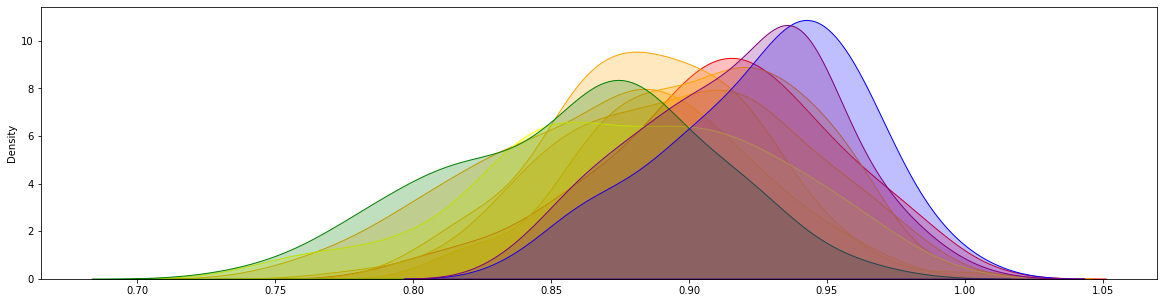

In [1710]:
#Precision / Sensitivity

plt.figure(figsize=(20,5))

sns.kdeplot(data = ct_AI_scores[2], color="red", shade=True)
sns.kdeplot(data = mv3_AI_scores[2], color="orange", shade=True)
sns.kdeplot(data = mv5_AI_scores[2], color="orange", shade=True)
sns.kdeplot(data = mv7_AI_scores[2], color="orange", shade=True)
sns.kdeplot(data = mv9_AI_scores[2], color="orange", shade=True)
sns.kdeplot(data = cons2_AI_scores[2], color="yellow", shade=True)
sns.kdeplot(data = cons3_AI_scores[2], color="green", shade=True)
sns.kdeplot(data = lca2_AI_scores[2], color="blue", shade=True)
sns.kdeplot(data = lca3_AI_scores[2], color="purple", shade=True)
plt.show()

In [1702]:
j = 2
for idx, silver in enumerate(names_wAI):
    print(silver)
    ct_lst = []
    silver_lst = []
    for i in range(10):
        ct_lst += ct_wAI_scores[i][j]
        exec(f"silver_lst += {silver}[i][j]")
#     print(ct_lst)
#     print(silver_lst)
    print(stats.ttest_ind(ct_lst, silver_lst,equal_var=False))

ct_wAI_scores
Ttest_indResult(statistic=0.0, pvalue=1.0)
indiv_wAI_scores
Ttest_indResult(statistic=-2.3625362084000545, pvalue=0.018258795193018332)
mv3_wAI_scores
Ttest_indResult(statistic=-2.1574887279700246, pvalue=0.03110345991447424)
mv5_wAI_scores
Ttest_indResult(statistic=-7.744117044048832, pvalue=1.6236201885320467e-14)
mv7_wAI_scores
Ttest_indResult(statistic=-7.049088667996693, pvalue=2.5779339812816616e-12)
mv9_wAI_scores
Ttest_indResult(statistic=-12.611288425324503, pvalue=6.052965310665758e-35)
cons2_wAI_scores
Ttest_indResult(statistic=-3.843858817117286, pvalue=0.00012513907581642952)
cons3_wAI_scores
Ttest_indResult(statistic=-4.533320832630264, pvalue=6.213258291575324e-06)
lca2_wAI_scores
Ttest_indResult(statistic=-16.859960864290045, pvalue=4.223682585929572e-59)
lca3_wAI_scores
Ttest_indResult(statistic=-14.755679290037877, pvalue=1.6673036236042398e-46)


# Lesion-based

In [1578]:
with open(f"./bootstrap_readertest", "rb") as fp:   # Unpickling
    sample_ids = pickle.load(fp)

In [1356]:
# without bootstrap
sample_ids = [list(range(1,101))]

In [171]:
# 1    2    3    4    5    6    7    8    9    10
# R11, R14, R15, R16, R20, R21, R23, R26, R28, R29

raters = ['R11', 'R14', 'R15', 'R16', 'R20', 'R21', 'R23', 'R26', 'R28', 'R29']

In [172]:
lesion_df = pd.read_csv('./Lesion_based_data/lesion_df.csv').reset_index()

In [189]:
def str2arr(strg):
    if strg in [0,'0']:
        return 0

    coors = strg[1:-1].split(' ')
    while '' in coors:
        coors.remove('')
    coors = np.array(coors).astype(float)
    return coors

# herbwood.tistory.com/3?category=867198
# Boolean function for intersection
def boxesIntersect(boxA, boxB):
    boxA = str2arr(boxA)
    boxB = str2arr(boxB)

#     if type(boxA) == int:
#         if type(boxB) == int: # TN
#             return False
#         else: # FP
#             return False
        
#     elif type(boxB) == int: # FN
#         return False
    
#     else: # TP 일수도 아닐 수도 (겹치면 True, 안겹치면 False)
    boxA = boxA.astype(float)
    boxB = boxB.astype(float)

    if boxA[0] > boxB[2]:
        return False # boxA is on the right of boxB
    if boxB[0] > boxA[2]:
        return False # boxA is on the left of boxB
    if boxA[3] < boxB[1]:
        return False # boxA is above boxB
    if boxA[1] > boxB[3]:
        return False # boxA is below boxB
    return True

def iou(A,B):  
    if boxesIntersect(A, B) != True:
        return 0
    
    A = str2arr(A).astype(float)
    B = str2arr(B).astype(float)
    
    # A = (x1, y1, x2, y2)
    A_area = (A[2] - A[0] + 1) * (A[3] - A[1] + 1)
    B_area = (B[2] - B[0] + 1) * (B[3] - B[1] + 1)

    # find intersection box
    x1 = max(A[0], B[0])
    y1 = max(A[1], B[1])
    x2 = min(A[2], B[2])
    y2 = min(A[3], B[3])

    # compute the width and height of the intersection
    w = max(0, x2 - x1 + 1)
    h = max(0, y2 - y1 + 1)

    inter = w * h
    iou_ = inter / (A_area + B_area - inter)

    return iou_

def check_box_in_list(box, boxlist, thres):
    for boxx in boxlist:
        if type(str2arr(boxx)) != int:
            if boxesIntersect(box, boxx):
                if iou(box, boxx)>thres:
                    return True
    return False
    
def marking(target, silver, thres):
    result = []
    
    pids = list(set(silver['DB_PatientId']))
    pids.sort()
    pids
    
    for caseId in pids:
#         print(f'===========Case {caseId}=========')
        target_ans = list(target[target['DB_PatientId']==caseId]['mask'])
        silver_ans = list(silver[silver['DB_PatientId']==caseId]['mask'])
#         print(target_ans)
#         print(silver_ans)
        for boxA in target_ans:
            if type(str2arr(boxA)) == int:
                if type(str2arr(silver_ans[0])) == int:
#                     print('TN')
                    result.append('TN')
            else:
                if check_box_in_list(boxA, silver_ans, thres):
#                     print('TP')
                    result.append('TP')
                elif not check_box_in_list(boxA, silver_ans, thres):
#                     print('FP')
                    result.append('FP')

        for boxB in silver_ans:
            if type(str2arr(boxB)) != int:
                if not check_box_in_list(boxB, target_ans, thres):
#                     print('FN')
                    result.append('FN')
            
    return result

def accuracies(target, silver, thres, prnt=True):
    result = marking(target,silver, thres)

    TP = result.count('TP')
    FP = result.count('FP')
    TN = result.count('TN')
    FN = result.count('FN')

    sensitivity = TP / (TP+FN)
    specificity = TN / (TN+FP)
    accuracy = (TP+TN)/(TP+FP+TN+FN)
    
    if prnt:
        print(f'TP {TP}')
        print(f'FP {FP}')
        print(f'TN {TN}')
        print(f'FN {FN}')
        print(f'sensitivity {sensitivity}')
        print(f'specificity {specificity}')
        print(f'accuracy {accuracy}')

    return sensitivity, specificity, accuracy

In [204]:
f'{[1,2]}'

'[1, 2]'

In [209]:
boxesIntersect('[ 388.2 1106.6  524.8 1252.2]', '[ 426 1150  489 1219]')


True

In [200]:
len(marking(woAI[0], lca2, 0.1))

94

In [174]:
def scores(silver_df, target_df, samples):
    sensitivities_ = []
    specificities_ = []
    accuracies_ = []
    for sample in samples:
        patients = set(silver_df['DB_PatientId'])
        sample = list(set(sample)-(set(sample)-patients))
        sample.sort()
        
        db_silver_ids = []
        msks_silver = []
        db_target_ids = []
        msks_target = []
        for num in sample:
            target = list(target_df[target_df['DB_PatientId']==num]['mask'])
            msks_target += target
            db_target_ids += [num for _ in target]
            
            silver = list(silver_df[silver_df['DB_PatientId']==num]['mask'])
            msks_silver += silver
            db_silver_ids += [num for _ in silver]
            
        sample_target = pd.DataFrame.from_dict({'DB_PatientId':db_target_ids, 'mask':msks_target})
        sample_silver = pd.DataFrame.from_dict({'DB_PatientId':db_silver_ids, 'mask':msks_silver})
        sens, spec, acc = accuracies(sample_target, sample_silver, THRES, False)
        sensitivities_.append(sens)
        specificities_.append(spec)
        accuracies_.append(acc)
        
    return sensitivities_,specificities_,accuracies_

In [175]:
THRES = 0.1

In [176]:
ct = pd.read_csv('./constructed/lesion-based_CT.csv')
indiv = pd.read_csv(f'./constructed/lesion-based_R20.csv')
mv3 = pd.read_csv(f'./constructed/lesion-based_3_majority_votes.csv')
mv3 = mv3[mv3['3vote32']==1][['DB_PatientId','mask']]
mv5 = pd.read_csv(f'./constructed/lesion-based_5_majority_votes.csv')
mv5 = mv5[mv5['5vote154']==1][['DB_PatientId','mask']]
mv7 = pd.read_csv(f'./constructed/lesion-based_7_majority_votes.csv')
mv7 = mv7[mv7['7vote0']==1][['DB_PatientId','mask']]
mv9 = pd.read_csv(f'./constructed/lesion-based_9_majority_votes.csv')
mv9 = mv9[mv9['9vote0']==1][['DB_PatientId','mask']]
cons2 = pd.read_csv(f'./constructed/lesion-based_consensus2.csv')
cons3 = pd.read_csv(f'./constructed/lesion-based_consensus3.csv')
lca2 = pd.read_csv(f'./constructed/lesion-based_lca_2.csv')
lca3 = pd.read_csv(f'./constructed/lesion-based_lca_3.csv')

In [177]:
woAI = []
wAI = []

raters = ['R12', 'R13', 'R17', 'R18', 'R19', 'R22', 'R24', 'R25', 'R27', 'R30']

for rater in raters:
    woAI.append(pd.read_csv(f'./Reader_test_lesion/Reader_AI-/{rater}_1.csv'))
    wAI.append(pd.read_csv(f'./Reader_test_lesion/Reader_AI+/{rater}_2.csv'))

AI = pd.read_csv(f'./Reader_test_lesion/AI/AI.csv')

In [1586]:
ct_woAI_scores = []
ct_wAI_scores = []
indiv_woAI_scores = []
indiv_wAI_scores = []
mv3_woAI_scores = []
mv3_wAI_scores = []
mv5_woAI_scores = []
mv5_wAI_scores = []
mv7_woAI_scores = []
mv7_wAI_scores = []
mv9_woAI_scores = []
mv9_wAI_scores = []
cons2_woAI_scores = []
cons2_wAI_scores = []
cons3_woAI_scores = []
cons3_wAI_scores = []
lca2_woAI_scores = []
lca2_wAI_scores = []
lca3_woAI_scores = []
lca3_wAI_scores = []

In [1587]:
for target in woAI:
    ct_woAI_scores.append(scores(ct, target, sample_ids))
    indiv_woAI_scores.append(scores(indiv, target, sample_ids))
    mv3_woAI_scores.append(scores(mv3, target, sample_ids))
    mv5_woAI_scores.append(scores(mv5, target, sample_ids))
    mv7_woAI_scores.append(scores(mv7, target, sample_ids))
    mv9_woAI_scores.append(scores(mv9, target, sample_ids))
    cons2_woAI_scores.append(scores(cons2, target, sample_ids))
    cons3_woAI_scores.append(scores(cons3, target, sample_ids))
    lca2_woAI_scores.append(scores(lca2, target, sample_ids))
    lca3_woAI_scores.append(scores(lca3, target, sample_ids))

In [1588]:
for target in wAI:
    ct_wAI_scores.append(scores(ct, target, sample_ids))
    indiv_wAI_scores.append(scores(indiv, target, sample_ids))
    mv3_wAI_scores.append(scores(mv3, target, sample_ids))
    mv5_wAI_scores.append(scores(mv5, target, sample_ids))
    mv7_wAI_scores.append(scores(mv7, target, sample_ids))
    mv9_wAI_scores.append(scores(mv9, target, sample_ids))
    cons2_wAI_scores.append(scores(cons2, target, sample_ids))
    cons3_wAI_scores.append(scores(cons3, target, sample_ids))
    lca2_wAI_scores.append(scores(lca2, target, sample_ids))
    lca3_wAI_scores.append(scores(lca3, target, sample_ids))

In [1589]:
ct_AI_scores = scores(ct, AI, sample_ids)
indiv_AI_scores = scores(indiv, AI, sample_ids)
mv3_AI_scores = scores(mv3, AI, sample_ids)
mv5_AI_scores = scores(mv5, AI, sample_ids)
mv7_AI_scores = scores(mv7, AI, sample_ids)
mv9_AI_scores = scores(mv9, AI, sample_ids)
cons2_AI_scores = scores(cons2, AI, sample_ids)
cons3_AI_scores = scores(cons3, AI, sample_ids)
lca2_AI_scores = scores(lca2, AI, sample_ids)
lca3_AI_scores = scores(lca3, AI, sample_ids)

## Distribution Comparison

In [1590]:
import pickle

list_dict = {'ct_woAI_scores': ct_woAI_scores,'ct_wAI_scores': ct_wAI_scores,'ct_AI_scores': ct_AI_scores,
            'indiv_woAI_scores': indiv_woAI_scores,'indiv_wAI_scores': indiv_wAI_scores,'indiv_AI_scores': indiv_AI_scores,
            'mv3_woAI_scores': mv3_woAI_scores,'mv3_wAI_scores': mv3_wAI_scores,'mv3_AI_scores': mv3_AI_scores,
            'mv5_woAI_scores': mv5_woAI_scores,'mv5_wAI_scores': mv5_wAI_scores,'mv5_AI_scores': mv5_AI_scores,
            'mv7_woAI_scores': mv7_woAI_scores,'mv7_wAI_scores': mv7_wAI_scores,'mv7_AI_scores': mv7_AI_scores,
            'mv9_woAI_scores': mv9_woAI_scores,'mv9_wAI_scores': mv9_wAI_scores,'mv9_AI_scores': mv9_AI_scores,
            'cons2_woAI_scores': cons2_woAI_scores,'cons2_wAI_scores': cons2_wAI_scores,'cons2_AI_scores': cons2_AI_scores,
            'cons3_woAI_scores': cons3_woAI_scores,'cons3_wAI_scores': cons3_wAI_scores,'cons3_AI_scores': cons3_AI_scores,
            'lca2_woAI_scores': lca2_woAI_scores,'lca2_wAI_scores': lca2_wAI_scores,'lca2_AI_scores': lca2_AI_scores,
            'lca3_woAI_scores': lca3_woAI_scores,'lca3_wAI_scores': lca3_wAI_scores,'lca3_AI_scores': lca3_AI_scores}

# for name in list_dict.keys():
#     with open(f"./Reader_test_result/lesion/{name}", "wb") as fp:   #Pickling
#         pickle.dump(list_dict[name], fp)

for name in list_dict.keys():
    with open(f"./Reader_test_result/lesion_bootstrap/{name}", "wb") as fp:   #Pickling
        pickle.dump(list_dict[name], fp)


In [1591]:
list_dict.keys()

dict_keys(['ct_woAI_scores', 'ct_wAI_scores', 'ct_AI_scores', 'indiv_woAI_scores', 'indiv_wAI_scores', 'indiv_AI_scores', 'mv3_woAI_scores', 'mv3_wAI_scores', 'mv3_AI_scores', 'mv5_woAI_scores', 'mv5_wAI_scores', 'mv5_AI_scores', 'mv7_woAI_scores', 'mv7_wAI_scores', 'mv7_AI_scores', 'mv9_woAI_scores', 'mv9_wAI_scores', 'mv9_AI_scores', 'cons2_woAI_scores', 'cons2_wAI_scores', 'cons2_AI_scores', 'cons3_woAI_scores', 'cons3_wAI_scores', 'cons3_AI_scores', 'lca2_woAI_scores', 'lca2_wAI_scores', 'lca2_AI_scores', 'lca3_woAI_scores', 'lca3_wAI_scores', 'lca3_AI_scores'])

In [20]:
dict_keys = ['ct_woAI_scores', 'ct_wAI_scores', 'ct_AI_scores',
             'indiv_woAI_scores', 'indiv_wAI_scores', 'indiv_AI_scores', 
             'mv3_woAI_scores', 'mv3_wAI_scores', 'mv3_AI_scores', 
             'mv5_woAI_scores', 'mv5_wAI_scores', 'mv5_AI_scores', 
             'mv7_woAI_scores', 'mv7_wAI_scores', 'mv7_AI_scores', 
             'mv9_woAI_scores', 'mv9_wAI_scores', 'mv9_AI_scores', 
             'cons2_woAI_scores', 'cons2_wAI_scores', 'cons2_AI_scores', 
             'cons3_woAI_scores', 'cons3_wAI_scores', 'cons3_AI_scores', 
             'lca2_woAI_scores', 'lca2_wAI_scores', 'lca2_AI_scores', 
             'lca3_woAI_scores', 'lca3_wAI_scores', 'lca3_AI_scores']

# for key in dict_keys:
#     with open(f"./Reader_test_result/lesion/{key}", "rb") as fp:   # Unpickling
#         exec("%s = pickle.load(fp)" % (key))
        
for key in dict_keys:
    with open(f"./Reader_test_result/lesion_bootstrap/{key}", "rb") as fp:   # Unpickling
        exec("%s = pickle.load(fp)" % (key))

In [1593]:
for j in range(3):
    lst = []
    for i in range(10):
        lst += lca3_woAI_scores[i][j]

    x = lst

    m = statistics.mean(x)
    s = statistics.stdev(x)

    dof = len(x)

    confidence = 0.95

    t_crit = np.abs(stats.t.ppf((1-confidence)/2,dof))

#     print(m)
    print((m-s*t_crit/np.sqrt(dof), m+s*t_crit/np.sqrt(dof)))

(0.8153437880091869, 0.8291151362365019)
(0.8333543187684513, 0.84647980868064)
(0.8300926344364785, 0.8396842937481015)


In [8]:
from scipy import stats

# 95% CI

my_AI_scores = cons3_AI_scores
my_woAI_scores = cons3_woAI_scores
my_wAI_scores = cons3_wAI_scores

# for i in range(1):
#     for j in range(3):
#         x = my_AI_scores[j]

#         m = statistics.mean(x)
# #         s = statistics.stdev(x)

#         dof = len(x)

#         confidence = 0.95

#         t_crit = np.abs(stats.t.ppf((1-confidence)/2,dof))

#         print(m)
# #         print((m-s*t_crit/np.sqrt(dof), m+s*t_crit/np.sqrt(dof)))

for scr in [my_woAI_scores, my_wAI_scores]:
    for i in range(10):
        for j in range(3):
            x = scr[i][j]

            m = statistics.mean(x)
    #         s = statistics.stdev(x)

            dof = len(x)

            confidence = 0.95

            t_crit = np.abs(stats.t.ppf((1-confidence)/2,dof))

            print(m)
#             print((m-s*t_crit/np.sqrt(dof), m+s*t_crit/np.sqrt(dof)))

    for j in range(3):
        lst = []
        for i in range(10):
            lst += scr[i][j]

        x = lst

        m = statistics.mean(x)
        s = statistics.stdev(x)

        dof = len(x)

        confidence = 0.95

        t_crit = np.abs(stats.t.ppf((1-confidence)/2,dof))

        print(m)
#         print((m-s*t_crit/np.sqrt(dof), m+s*t_crit/np.sqrt(dof)))

0.7212127488524548
0.9314209677936881
0.8699440679425625
0.7758975681181564
0.7995812356210321
0.7941566632132108
0.8128752236325766
0.9024555541010401
0.8765447040003562
0.7422779459102988
0.7261947838217956
0.7321882401635276
0.8182650698974229
0.6205319485346057
0.6788872048416627
0.8599291321423674
0.9235741863968381
0.9052741859195875
0.8402817615391145
0.7745699865626808
0.7948474898814416
0.9276329601770779
0.8199850772068342
0.8509289452650977
0.8501452493584847
0.8359762771877858
0.839596526304675
0.7693892569848452
0.8283202220695521
0.8105902670308962
0.8117906916612799
0.8162610239295852
0.8152958294563017
0.7920928075192781
0.9466500368802531
0.9011828119308272
0.8356563771196124
0.7981609100565185
0.8092401232215498
0.6492497771836007
0.9740116173836835
0.8768563833900102
0.8454737223560753
0.87127787909331
0.8641055470874722
0.9702874209124209
0.7265836477297004
0.7965749536161382
0.9387570762570763
0.8289764355963186
0.8625419875649565
0.9072792999484176
0.8573172048544

In [1644]:
np.array(cons2_wAI_scores).shape

(10, 3, 100)

In [10]:
from scipy import stats

names_AI = ['ct_AI_scores', 'indiv_AI_scores', 'mv3_AI_scores', 'mv5_AI_scores', 'mv7_AI_scores',
            'mv9_AI_scores', 'cons2_AI_scores', 'cons3_AI_scores', 'lca2_AI_scores', 'lca3_AI_scores']
names_woAI = ['ct_woAI_scores','indiv_woAI_scores','mv3_woAI_scores', 'mv5_woAI_scores', 'mv7_woAI_scores',
              'mv9_woAI_scores', 'cons2_woAI_scores', 'cons3_woAI_scores', 'lca2_woAI_scores', 'lca3_woAI_scores']
names_wAI = ['ct_wAI_scores', 'indiv_wAI_scores', 'mv3_wAI_scores', 'mv5_wAI_scores', 'mv7_wAI_scores',
            'mv9_wAI_scores', 'cons2_wAI_scores', 'cons3_wAI_scores', 'lca2_wAI_scores', 'lca3_wAI_scores']

names_AI_comb = list(combinations(names_AI,2))
names_woAI_comb = list(combinations(names_woAI,2))
names_wAI_comb = list(combinations(names_wAI,2))

j = 2

if j == 0:
    print("/////Sensitivity")
elif j == 1:
    print("/////Specificity")
elif j == 2:
    print("/////Accuracy")

# print("==========AI_score==========")
# for idx, silver in enumerate(names_AI):
#     exec(f"t_stat, p_val = stats.ttest_ind(ct_AI_scores[j], {silver}[j],equal_var=False)")  
#     print(silver)
#     print(f"t-statistics:{t_stat}, p-value: {p_val}")

# print("==========woAI_score==========")
# for i, rater in enumerate(raters):
#     print(f"----------{rater}----------")
#     for idx, silver in enumerate(names_woAI):
#         exec(f"t_stat, p_val = stats.ttest_ind(ct_woAI_scores[i][j], {silver}[i][j],equal_var=False)")
#         print(silver)
#         print(f"t-statistics:{t_stat}, p-value: {p_val}")
        
print("==========wAI_score==========")
for i, rater in enumerate(raters):
    print(f"----------{rater}----------")
    for idx, silver in enumerate(names_wAI):
        exec(f"t_stat, p_val = stats.ttest_ind(ct_wAI_scores[i][j], {silver}[i][j],equal_var=False)")
        print(silver)
        print(f"t-statistics:{t_stat}, p-value: {p_val}")

/////Accuracy
==========wAI_score==========


NameError: name 'raters' is not defined

In [ ]:
for i, rater in enumerate(raters):
    print(f"----------{rater}----------")
    for idx, silver in enumerate(names_wAI):
        exec(f"t_stat, p_val = stats.ttest_ind(ct_wAI_scores[i][j], {silver}[i][j],equal_var=False)")
        print(silver)
        print(f"t-statistics:{t_stat}, p-value: {p_val}")

t_stat, p_val = stats.ttest_ind(ct_wAI_scores[i][j], {silver}[i][j],equal_var=False)

### 20220407 통계적 유의성 체크

In [11]:
import pandas as pd
import numpy as np
from itertools import combinations
import statistics
import math
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

#### Image-based

In [156]:
dict_keys = ['ct_woAI_scores', 'ct_wAI_scores', 'ct_AI_scores',
             'indiv_woAI_scores', 'indiv_wAI_scores', 'indiv_AI_scores', 
             'mv3_woAI_scores', 'mv3_wAI_scores', 'mv3_AI_scores', 
             'mv5_woAI_scores', 'mv5_wAI_scores', 'mv5_AI_scores', 
             'mv7_woAI_scores', 'mv7_wAI_scores', 'mv7_AI_scores', 
             'mv9_woAI_scores', 'mv9_wAI_scores', 'mv9_AI_scores', 
             'cons2_woAI_scores', 'cons2_wAI_scores', 'cons2_AI_scores', 
             'cons3_woAI_scores', 'cons3_wAI_scores', 'cons3_AI_scores', 
             'lca2_woAI_scores', 'lca2_wAI_scores', 'lca2_AI_scores', 
             'lca3_woAI_scores', 'lca3_wAI_scores', 'lca3_AI_scores']

# for key in dict_keys:
#     with open(f"./Reader_test_result/image/{key}", "rb") as fp:   # Unpickling
#         exec("%s = pickle.load(fp)" % (key))
        
for key in dict_keys:
    with open(f"./Reader_test_result/image_bootstrap/{key}", "rb") as fp:   # Unpickling
        exec("%s = pickle.load(fp)" % (key))

In [124]:
j = 0

ct_lst = []
silver_lst = []
for i in range(10):
    ct_lst += cons2_woAI_scores[i][j]
    silver_lst += cons3_woAI_scores[i][j]
#     exec(f"silver_lst += {silver}[i][j]")
print(stats.ttest_ind(ct_lst, silver_lst,equal_var=False))

Ttest_indResult(statistic=-0.43073999626484244, pvalue=0.6667039032223707)


In [148]:
np.array([1,2,3,4])-np.array([3,2,3,2])

array([-2,  0,  0,  2])

In [151]:
# Differences with reference standard w/o AI vs. w/ AI p-value (가로)

j = 2

for silver in ['indiv', 'mv7', 'cons2', 'cons3', 'lca2']:
    ct_lst = []
    silver_lst = []
    print("=========="+silver+"==========")
    for i in range(10):
        exec(f"ct_lst += list(np.array({silver}_woAI_scores[i][j]) - np.array(ct_woAI_scores[i][j]))")
        exec(f"silver_lst += list(np.array({silver}_wAI_scores[i][j]) - np.array(ct_wAI_scores[i][j]))")
    print(stats.ttest_ind(ct_lst, silver_lst,equal_var=False))

==========indiv==========
Ttest_indResult(statistic=8.726044704008478, pvalue=5.537910167873297e-18)
==========mv7==========
Ttest_indResult(statistic=11.524178396721357, pvalue=8.70314454206386e-30)
==========cons2==========
Ttest_indResult(statistic=8.126949271990755, pvalue=7.751327348930017e-16)
==========cons3==========
Ttest_indResult(statistic=7.55255212812587, pvalue=6.45586767315383e-14)
==========lca2==========
Ttest_indResult(statistic=6.011261563052932, pvalue=2.183688606056287e-09)


In [166]:
# "added value by AI subjective standard vs.reference standard (세로)"
			

j = 2

for silver in ['indiv', 'mv7', 'cons2', 'cons3', 'lca2']:
    ct_lst = []
    silver_lst = []
#     print("=========="+silver+"==========")
    for i in range(10):
        exec(f"ct_lst += list(np.array({silver}_wAI_scores[i][j]) - np.array({silver}_woAI_scores[i][j]))")
        exec(f"silver_lst += list(np.array(ct_wAI_scores[i][j]) - np.array(ct_woAI_scores[i][j]))")
    print(stats.ttest_ind(ct_lst, silver_lst,equal_var=False)[1])

1.9653822086808047e-13
1.5995681663575206e-22
4.911112366372214e-15
1.8671917322982935e-14
1.4496342545837281e-06


In [129]:
j = 0

ct_lst = mv7_AI_scores[j]
silver_lst = cons3_AI_scores[j]

print(stats.ttest_ind(ct_lst, silver_lst,equal_var=False))

Ttest_indResult(statistic=0.5876908187532022, pvalue=0.5574096860971742)


##### Lesion-based

In [167]:
dict_keys = ['ct_woAI_scores', 'ct_wAI_scores', 'ct_AI_scores',
             'indiv_woAI_scores', 'indiv_wAI_scores', 'indiv_AI_scores', 
             'mv3_woAI_scores', 'mv3_wAI_scores', 'mv3_AI_scores', 
             'mv5_woAI_scores', 'mv5_wAI_scores', 'mv5_AI_scores', 
             'mv7_woAI_scores', 'mv7_wAI_scores', 'mv7_AI_scores', 
             'mv9_woAI_scores', 'mv9_wAI_scores', 'mv9_AI_scores', 
             'cons2_woAI_scores', 'cons2_wAI_scores', 'cons2_AI_scores', 
             'cons3_woAI_scores', 'cons3_wAI_scores', 'cons3_AI_scores', 
             'lca2_woAI_scores', 'lca2_wAI_scores', 'lca2_AI_scores', 
             'lca3_woAI_scores', 'lca3_wAI_scores', 'lca3_AI_scores']

# for key in dict_keys:
#     with open(f"./Reader_test_result/lesion/{key}", "rb") as fp:   # Unpickling
#         exec("%s = pickle.load(fp)" % (key))
        
for key in dict_keys:
    with open(f"./Reader_test_result/lesion_bootstrap/{key}", "rb") as fp:   # Unpickling
        exec("%s = pickle.load(fp)" % (key))

In [138]:
# reference standard / with and without AI

j = 0

ct_lst = []
silver_lst = []
for i in range(10):
    ct_lst += indiv_wAI_scores[i][j]
    silver_lst += cons2_wAI_scores[i][j]
#     exec(f"silver_lst += {silver}[i][j]")
print(stats.ttest_ind(ct_lst, silver_lst,equal_var=False))

Ttest_indResult(statistic=-12.232239228421607, pvalue=3.2409921691697505e-33)


In [55]:
# subjective standard / with and without AI

j = 2

for silver in ['indiv', 'mv7', 'cons2', 'cons3', 'lca2']:
    ct_lst = []
    silver_lst = []
    print("=========="+silver+"==========")
    for i in range(10):
        exec(f"ct_lst += {silver}_woAI_scores[i][j]")
        exec(f"silver_lst += {silver}_wAI_scores[i][j]")
    print(stats.ttest_ind(ct_lst, silver_lst,equal_var=False))

==========indiv==========
Ttest_indResult(statistic=-4.279656078880225, pvalue=1.9645888925589996e-05)
==========mv7==========
Ttest_indResult(statistic=-6.4204410491567465, pvalue=1.7272017231481971e-10)
==========cons2==========
Ttest_indResult(statistic=-3.804938742391392, pvalue=0.00014614350419431604)
==========cons3==========
Ttest_indResult(statistic=-10.350748074731904, pvalue=2.031737077124743e-24)
==========lca2==========
Ttest_indResult(statistic=-12.392128264537478, pvalue=8.350364413436006e-34)


In [104]:
j = 1

ct_lst = []
silver_lst = []
for i in range(10):
    ct_lst += indiv_woAI_scores[i][j]
    silver_lst += mv7_woAI_scores[i][j]
#     exec(f"silver_lst += {silver}[i][j]")
print(stats.ttest_ind(ct_lst, silver_lst,equal_var=False))

Ttest_indResult(statistic=-0.010031355174875157, pvalue=0.9919972723516441)


In [143]:
j = 0

ct_lst = lca2_AI_scores[j]
silver_lst = cons2_AI_scores[j]
print(stats.ttest_ind(ct_lst, silver_lst,equal_var=False))

Ttest_indResult(statistic=8.881800948306662, pvalue=2.5542006757031345e-15)


In [155]:
# with and without AI

j = 2

for silver in ['indiv', 'mv7', 'cons2', 'cons3', 'lca2']:
    ct_lst = []
    silver_lst = []
    print("=========="+silver+"==========")
    for i in range(10):
        exec(f"ct_lst += list(np.array({silver}_woAI_scores[i][j]) - np.array(ct_woAI_scores[i][j]))")
        exec(f"silver_lst += list(np.array({silver}_wAI_scores[i][j]) - np.array(ct_wAI_scores[i][j]))")
    print(stats.ttest_ind(ct_lst, silver_lst,equal_var=False))

==========indiv==========
Ttest_indResult(statistic=22.930094341995087, pvalue=2.5207688958955944e-103)
==========mv7==========
Ttest_indResult(statistic=22.02292936540943, pvalue=2.7312053547433173e-96)
==========cons2==========
Ttest_indResult(statistic=22.44567885393842, pvalue=2.8191101915339625e-99)
==========cons3==========
Ttest_indResult(statistic=16.035578987465957, pvalue=1.7563213700452184e-54)
==========lca2==========
Ttest_indResult(statistic=16.11250377031806, pvalue=5.275400983160513e-55)


In [170]:
# "added value by AI subjective standard vs.reference standard (세로)"
			

j = 2

for silver in ['indiv', 'mv7', 'cons2', 'cons3', 'lca2']:
    ct_lst = []
    silver_lst = []
#     print("=========="+silver+"==========")
    for i in range(10):
        exec(f"ct_lst += list(np.array({silver}_wAI_scores[i][j]) - np.array({silver}_woAI_scores[i][j]))")
        exec(f"silver_lst += list(np.array(ct_wAI_scores[i][j]) - np.array(ct_woAI_scores[i][j]))")
    print(stats.ttest_ind(ct_lst, silver_lst,equal_var=False)[1])

8.398092649058501e-78
4.4573807336849766e-69
1.974743186614859e-98
5.1015903037354293e-45
1.7001124715876106e-41


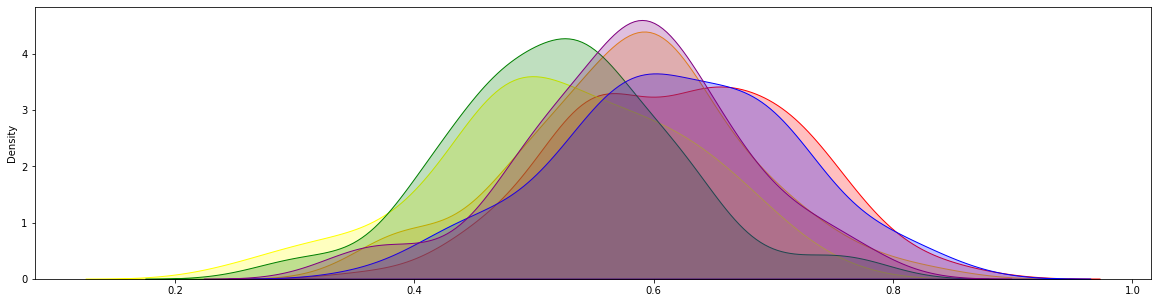

In [309]:
#Precision / Sensitivity

plt.figure(figsize=(20,5))

sns.kdeplot(data = indiv_scores[0], color="red", shade=True)
sns.kdeplot(data = mv_scores[0], color="orange", shade=True)
sns.kdeplot(data = cons2_scores[0], color="yellow", shade=True)
sns.kdeplot(data = cons3_scores[0], color="green", shade=True)
sns.kdeplot(data = lca2_scores[0], color="blue", shade=True)
sns.kdeplot(data = lca3_scores[0], color="purple", shade=True)
plt.show()

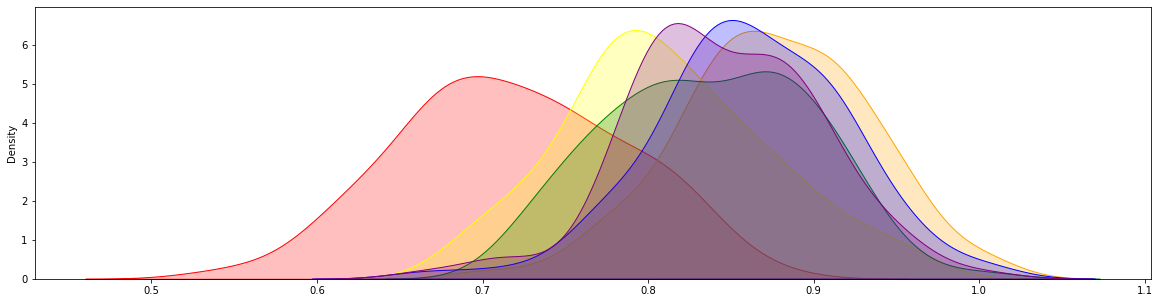

In [310]:
#Recall / Specificity

plt.figure(figsize=(20,5))

sns.kdeplot(data = indiv_scores[1], color="red", shade=True)
sns.kdeplot(data = mv_scores[1], color="orange", shade=True)
sns.kdeplot(data = cons2_scores[1], color="yellow", shade=True)
sns.kdeplot(data = cons3_scores[1], color="green", shade=True)
sns.kdeplot(data = lca2_scores[1], color="blue", shade=True)
sns.kdeplot(data = lca3_scores[1], color="purple", shade=True)
plt.show()

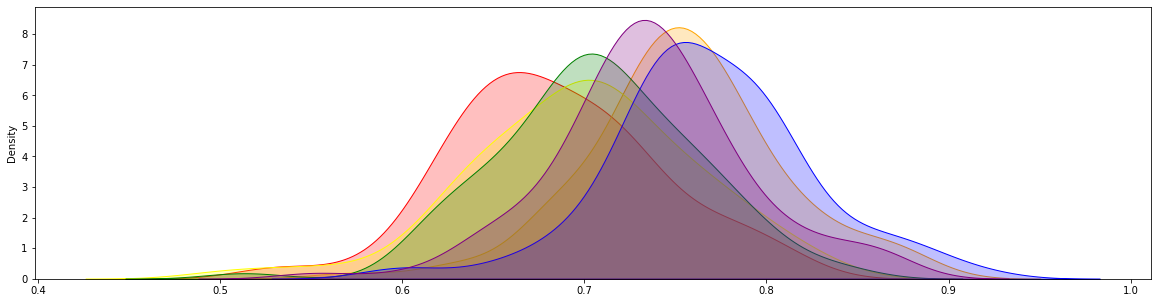

In [311]:
#f1-score / Accuracy

plt.figure(figsize=(20,5))

sns.kdeplot(data = indiv_scores[2], color="red", shade=True)
sns.kdeplot(data = mv_scores[2], color="orange", shade=True)
sns.kdeplot(data = cons2_scores[2], color="yellow", shade=True)
sns.kdeplot(data = cons3_scores[2], color="green", shade=True)
sns.kdeplot(data = lca2_scores[2], color="blue", shade=True)
sns.kdeplot(data = lca3_scores[2], color="purple", shade=True)
plt.show()

In [312]:
#Precision / Sensitivity

from scipy import stats

names = ['indiv_scores','mv_scores','cons2_scores','cons3_scores','lca2_scores','lca3_scores']
names_combs = list(combinations(names,2))

for idx, comb in enumerate(list(combinations([indiv_scores[0],mv_scores[0],cons2_scores[0],cons3_scores[0],lca2_scores[0],lca3_scores[0]],2))):
    t_stat, p_val = stats.ttest_ind(list(comb)[0], list(comb)[1],
                                    equal_var=False)
    print(names_combs[idx])
    print(f"t-statistics:{t_stat}, p-value: {p_val}")

('indiv_scores', 'mv_scores')
t-statistics:3.043664535196646, p-value: 0.002654577945732798
('indiv_scores', 'cons2_scores')
t-statistics:6.789753604213675, p-value: 1.294757580382e-10
('indiv_scores', 'cons3_scores')
t-statistics:7.392892514159448, p-value: 3.979655002828642e-12
('indiv_scores', 'lca2_scores')
t-statistics:0.38280826877980534, p-value: 0.7022728626276777
('indiv_scores', 'lca3_scores')
t-statistics:3.148513113760472, p-value: 0.0018956907661983335
('mv_scores', 'cons2_scores')
t-statistics:3.931017827406721, p-value: 0.0001172305715600528
('mv_scores', 'cons3_scores')
t-statistics:4.359525920862279, p-value: 2.093903939557607e-05
('mv_scores', 'lca2_scores')
t-statistics:-2.6150160906554505, p-value: 0.009610621582943207
('mv_scores', 'lca3_scores')
t-statistics:0.05348004994306102, p-value: 0.9574034121910329
('cons2_scores', 'cons3_scores')
t-statistics:0.16511583636624705, p-value: 0.8690237024896735
('cons2_scores', 'lca2_scores')
t-statistics:-6.336547800033757, 

In [313]:
#Recall / Specificity

from scipy import stats

names = ['indiv_scores','mv_scores','cons2_scores','cons3_scores','lca2_scores','lca3_scores']
names_combs = list(combinations(names,2))

for idx, comb in enumerate(list(combinations([indiv_scores[1],mv_scores[1],cons2_scores[1],cons3_scores[1],lca2_scores[1],lca3_scores[1]],2))):
    t_stat, p_val = stats.ttest_ind(list(comb)[0], list(comb)[1],
                                    equal_var=False)
    print(names_combs[idx])
    print(f"t-statistics:{t_stat}, p-value: {p_val}")

('indiv_scores', 'mv_scores')
t-statistics:-17.583777845996664, p-value: 6.668289630737618e-42
('indiv_scores', 'cons2_scores')
t-statistics:-10.047904408885769, p-value: 1.975902448177396e-19
('indiv_scores', 'cons3_scores')
t-statistics:-13.020854374909922, p-value: 2.568700096058611e-28
('indiv_scores', 'lca2_scores')
t-statistics:-15.880471901536565, p-value: 6.680423302967779e-37
('indiv_scores', 'lca3_scores')
t-statistics:-14.270853512592135, p-value: 5.467210435052819e-32
('mv_scores', 'cons2_scores')
t-statistics:7.559635022966349, p-value: 1.50139545548422e-12
('mv_scores', 'cons3_scores')
t-statistics:4.5108440114353145, p-value: 1.1071347612516577e-05
('mv_scores', 'lca2_scores')
t-statistics:1.7325083930484069, p-value: 0.08474066453009085
('mv_scores', 'lca3_scores')
t-statistics:3.6455469691353244, p-value: 0.00034097269030747745
('cons2_scores', 'cons3_scores')
t-statistics:-3.0172131649387923, p-value: 0.0028862310264982757
('cons2_scores', 'lca2_scores')
t-statistics:

In [314]:
#f1-score / Accuracy

from scipy import stats

names = ['indiv_scores','mv_scores','cons2_scores','cons3_scores','lca2_scores','lca3_scores']
names_combs = list(combinations(names,2))

for idx, comb in enumerate(list(combinations([indiv_scores[2],mv_scores[2],cons2_scores[2],cons3_scores[2],lca2_scores[2],lca3_scores[2]],2))):
    t_stat, p_val = stats.ttest_ind(list(comb)[0], list(comb)[1],
                                    equal_var=False)
    print(names_combs[idx])
    print(f"t-statistics:{t_stat}, p-value: {p_val}")

('indiv_scores', 'mv_scores')
t-statistics:-8.911585706012003, p-value: 3.3567507063281383e-16
('indiv_scores', 'cons2_scores')
t-statistics:-1.8605452605359976, p-value: 0.06430043268185014
('indiv_scores', 'cons3_scores')
t-statistics:-2.894255494536307, p-value: 0.004227497969082207
('indiv_scores', 'lca2_scores')
t-statistics:-10.557961157690643, p-value: 5.9270364940756646e-21
('indiv_scores', 'lca3_scores')
t-statistics:-6.6132197998172035, p-value: 3.4428722376939834e-10
('mv_scores', 'cons2_scores')
t-statistics:6.627389789916208, p-value: 3.274646300031708e-10
('mv_scores', 'cons3_scores')
t-statistics:6.129293095499194, p-value: 4.6917758047082264e-09
('mv_scores', 'lca2_scores')
t-statistics:-1.8023031768910869, p-value: 0.07301958309878132
('mv_scores', 'lca3_scores')
t-statistics:2.370070831324488, p-value: 0.018745596438129907
('cons2_scores', 'cons3_scores')
t-statistics:-0.8773994732878927, p-value: 0.38134837535845634
('cons2_scores', 'lca2_scores')
t-statistics:-8.235

In [333]:
# 95% CI

# [indiv_scores,mv_scores,cons2_scores,cons3_scores,lca2_scores,lca3_scores]
x = lca3_scores[2]

m = statistics.mean(x)
s = statistics.stdev(x)

dof = len(x)

confidence = 0.95

t_crit = np.abs(stats.t.ppf((1-confidence)/2,dof))

m, (m-s*t_crit/np.sqrt(dof), m+s*t_crit/np.sqrt(dof))

(0.7356658237214854, (0.7249345368672816, 0.7463971105756891))

In [22]:
statistics.mean(rec), statistics.stdev(rec)

(0.4848575043087241, 0.09442735330513066)

In [23]:
silvergt = pd.read_csv('./constructed/lesion-based_R20.csv')
silvergt = silvergt[['DB_PatientId','mask']]
silvergt = silvergt.reset_index(drop=True)
f1score(silvergt,THRES)

TP 23
FP 18
TN 47
FN 14
precision 0.5609756097560976
recall 0.6216216216216216
f1-score 0.5897435897435899


(0.5609756097560976, 0.6216216216216216, 0.5897435897435899)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 1.0)

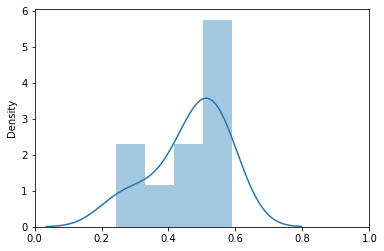

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.distplot(f1s)
plt.xlim(0, 1)
# plt.title('3 majority votes [n=120]')

## MV

In [197]:
k = 9
i = 7 # len(list(combinations(raters,k)))

In [198]:
len(list(combinations(raters,k))), list(combinations(raters,k))[i]

(10, ('R11', 'R14', 'R16', 'R20', 'R21', 'R23', 'R26', 'R28', 'R29'))

In [199]:
silvergt = pd.read_csv(f'./constructed/lesion-based_{k}_majority_votes.csv')
silvergt = silvergt[silvergt[f'{k}vote{i}']==1][['DB_PatientId','mask']]
silvergt = silvergt.reset_index(drop=True)
f1score(silvergt,THRES)

TP 23
FP 7
TN 50
FN 17
precision 0.7666666666666667
recall 0.575
f1-score 0.6571428571428571


(0.7666666666666667, 0.575, 0.6571428571428571)

In [28]:
omit_lst = list(set(range(1,101))-set(silvergt['DB_PatientId']))
omit_lst

[64, 49, 73]

### MV average f1-score

In [29]:
def average_score(k, score):
    if score == 'precision': idx = 0
    elif score == 'recall': idx = 1
    elif score == 'f1': idx = 2
        
    scores=[]
    for i in range(len(list(combinations(raters,k)))):
        selected_raters = list(combinations(raters,k))[i]
        majority_votes_df = pd.read_csv(f'./constructed/lesion-based_{k}_majority_votes.csv')
        majority_votes_df = majority_votes_df[majority_votes_df[f'{k}vote{i}']==1][['DB_PatientId','mask']]
        majority_votes_df = majority_votes_df.reset_index(drop=True)
        scores.append(f1score(majority_votes_df,THRES,prnt=False)[idx])

    average_score_ = statistics.mean(scores)
    sd_score_ = statistics.stdev(scores)
    print(f'=={k} majority votes f1-score [n = {len(list(combinations(raters,k)))}]==')
    print(f'ㄴaverage: {average_score_}')
    print(f'ㄴstandard deviation: {sd_score_}')

    return scores, average_score_, sd_score_

In [30]:
avg_precision_9 = average_score(9,'precision')[0]
avg_precision_7 = average_score(7,'precision')[0]
avg_precision_5 = average_score(5,'precision')[0]
avg_precision_3 = average_score(3,'precision')[0]

avg_recall_9 = average_score(9,'recall')[0]
avg_recall_7 = average_score(7,'recall')[0]
avg_recall_5 = average_score(5,'recall')[0]
avg_recall_3 = average_score(3,'recall')[0]

avg_f1_9 = average_score(9,'f1')[0]
avg_f1_7 = average_score(7,'f1')[0]
avg_f1_5 = average_score(5,'f1')[0]
avg_f1_3 = average_score(3,'f1')[0]

==9 majority votes f1-score [n = 10]==
ㄴaverage: 0.7581182795698924
ㄴstandard deviation: 0.015706226514224993
==7 majority votes f1-score [n = 120]==
ㄴaverage: 0.762760068753319
ㄴstandard deviation: 0.026376233292309655
==5 majority votes f1-score [n = 252]==
ㄴaverage: 0.7614029236121937
ㄴstandard deviation: 0.029258420884323066
==3 majority votes f1-score [n = 120]==
ㄴaverage: 0.7430842454442108
ㄴstandard deviation: 0.03618243117672269
==9 majority votes f1-score [n = 10]==
ㄴaverage: 0.5952810967380929
ㄴstandard deviation: 0.021682591979676542
==7 majority votes f1-score [n = 120]==
ㄴaverage: 0.5926823585424356
ㄴstandard deviation: 0.02926313730758341
==5 majority votes f1-score [n = 252]==
ㄴaverage: 0.5817162058730867
ㄴstandard deviation: 0.04260711772111495
==3 majority votes f1-score [n = 120]==
ㄴaverage: 0.5716860471368338
ㄴstandard deviation: 0.057873957738516855
==9 majority votes f1-score [n = 10]==
ㄴaverage: 0.6667740257972958
ㄴstandard deviation: 0.017837947819285042
==7 majo

In [57]:
from scipy import stats

In [74]:
# 95% CI

x = avg_recall_3

m = statistics.mean(x)
s = statistics.stdev(x)

dof = len(x)

confidence = 0.95

t_crit = np.abs(stats.t.ppf((1-confidence)/2,dof))

(m-s*t_crit/np.sqrt(dof), m+s*t_crit/np.sqrt(dof))

(0.5612257870090457, 0.5821463072646219)

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

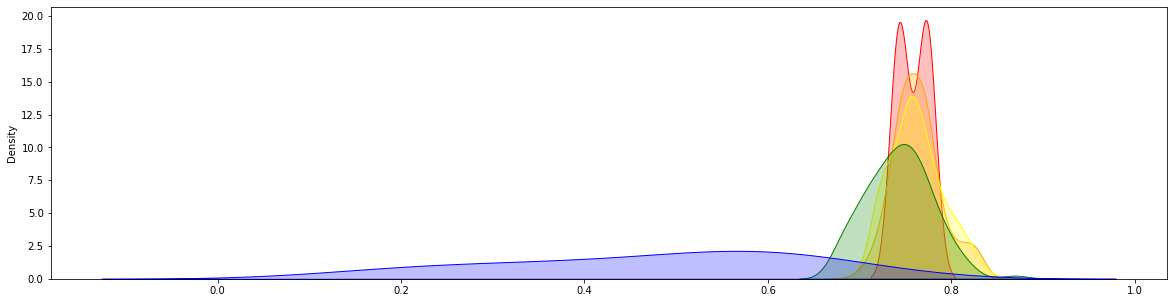

In [24]:
plt.figure(figsize=(20,5))

sns.kdeplot(data = avg_precision_9, color="red", shade=True)
sns.kdeplot(data = avg_precision_7, color="orange", shade=True)
sns.kdeplot(data = avg_precision_5, color="yellow", shade=True)
sns.kdeplot(data = avg_precision_3, color="green", shade=True)
sns.kdeplot(data = prec, color="blue", shade=True) # prec, rec, f1
plt.show()

In [25]:
from scipy import stats

t_stat, p_val = stats.ttest_ind(avg_f1_5, avg_f1_3,
                                equal_var=False)
print(f"t-statistics:{t_stat}, p-value: {p_val}")

t-statistics:3.8514632252418575, p-value: 0.00015918453018197172


## Consensus

In [27]:
silvergt = pd.read_csv('./constructed/lesion-based_consensus2.csv')
silvergt = silvergt[['DB_PatientId','mask']]
silvergt = silvergt.reset_index(drop=True)
f1score(silvergt,THRES)

TP 21
FP 11
TN 50
FN 19
precision 0.65625
recall 0.525
f1-score 0.5833333333333334


(0.65625, 0.525, 0.5833333333333334)

In [28]:
silvergt = pd.read_csv('./constructed/lesion-based_consensus3.csv')
silvergt = silvergt[['DB_PatientId','mask']]
silvergt = silvergt.reset_index(drop=True)
f1score(silvergt,THRES)

TP 21
FP 10
TN 49
FN 20
precision 0.6774193548387096
recall 0.5121951219512195
f1-score 0.5833333333333334


(0.6774193548387096, 0.5121951219512195, 0.5833333333333334)

## LCA

In [29]:
silvergt = pd.read_csv('./constructed/lesion-based_lca_2.csv')
silvergt = silvergt[['DB_PatientId','mask']]
silvergt = silvergt.reset_index(drop=True)
f1score(silvergt,THRES)

TP 22
FP 8
TN 50
FN 14
precision 0.7333333333333333
recall 0.6111111111111112
f1-score 0.6666666666666666


(0.7333333333333333, 0.6111111111111112, 0.6666666666666666)

In [30]:
silvergt = pd.read_csv('./constructed/lesion-based_lca_3.csv')
silvergt = silvergt[['DB_PatientId','mask']]
silvergt = silvergt.reset_index(drop=True)
f1score(silvergt,THRES)

TP 24
FP 9
TN 50
FN 18
precision 0.7272727272727273
recall 0.5714285714285714
f1-score 0.64


(0.7272727272727273, 0.5714285714285714, 0.64)

In [ ]:
# Target journal
IF >10
(25) Lancet digital health
(11 ->20?) Radiology v
(12) NPJ digital medicine (do as ai says)